<a href="https://colab.research.google.com/github/ram130849/object_detection_using_retinanet/blob/main/Object_Detection_using_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q -U opencv-python
!pip install -q -U albumentations
!pip install -q -U bounding-box

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322761, done.
remote: Counting objects: 100% (746/746), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 322761 (delta 621), reused 717 (delta 610), pack-reused 322015
Receiving objects: 100% (322761/322761), 653.64 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (296651/296651), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!cp -R /content/gdrive/MyDrive/images.tar.gz /content/

In [7]:
!tar xf /content/gdrive/MyDrive/images.tar.gz
!tar xf /content/gdrive/MyDrive/annotations.tar.gz

In [8]:
import sys
import os
import re
import cv2
import torch
import torchvision
import time
import math
import torch.nn as nn
import utils
import numpy as np
import pandas as pd
import albumentations as A
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import model_selection, preprocessing
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.ops import misc
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from albumentations.pytorch import ToTensorV2
from PIL import Image
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow
from functools import partial
import torch.nn as nn
import torch.nn.functional as F

In [9]:
img_desc = Path("/content/images")
ims = list(img_desc.iterdir())
ims = [str(pth) for pth in ims]

img_pths = []
print("[INFO] Gatering images")
# Accept only the image files
for im in tqdm(ims):
    if im.split(os.path.sep)[-1].split(".")[-1] == "jpg":
        img_pths.append(im)

img_pths[:5], len(img_pths)

[INFO] Gatering images


  0%|          | 0/7393 [00:00<?, ?it/s]

(['/content/images/miniature_pinscher_100.jpg',
  '/content/images/samoyed_38.jpg',
  '/content/images/Russian_Blue_212.jpg',
  '/content/images/Siamese_103.jpg',
  '/content/images/Birman_178.jpg'],
 7390)

In [10]:
# Clear out the images that open_cv cannot open
for pth in tqdm(img_pths):
    try: _ = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    except:
        img_pths.remove(pth)
        print(f"[INFO] Corrupted image: {pth}")

  0%|          | 0/7390 [00:00<?, ?it/s]

[INFO] Corrupted image: /content/images/Egyptian_Mau_145.jpg
[INFO] Corrupted image: /content/images/Abyssinian_34.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_177.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_139.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_167.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_191.jpg


In [11]:
annot_dir = Path("/content/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]

ann_pths = []
print("[INFO] Creating the paths to the annotations ...")
for a in tqdm(annots):
    for i in img_pths:
        # Check if the annotation file for an image is in 
        # our verified img_pths or not
        i_pth = i.split(os.path.sep)[-1].split(".")[0]
        a_pth = a.split(os.path.sep)[-1].split(".")[0]
        if(i_pth == a_pth): 
            ann_pths.append(a)
print("Annotation files found : ", len(ann_pths))

[INFO] Creating the paths to the annotations ...


  0%|          | 0/3686 [00:00<?, ?it/s]

Annotation files found :  3686


In [12]:
def xml_to_csv(pths:list) -> pd.DataFrame:
    """Extracts the filenames and the bboxes from the xml_list"""
    print("[INFO] Gathering the filenames and bboxes")
    xml_list = []
    for xml_file in tqdm(pths):
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [13]:
df = xml_to_csv(ann_pths)

[INFO] Gathering the filenames and bboxes


  0%|          | 0/3686 [00:00<?, ?it/s]

In [14]:
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

# 1. Extract the label
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
# 2. Convert the classes to integers
df["target"] = preprocessing.LabelEncoder().fit_transform(df["class"].values) + 1
# 3. Shuffle the dataFrame
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/scottish_terrier_185.jpg,51.0,1.0,389.0,358.0,scottish_terrier,31
1,/content/images/Russian_Blue_146.jpg,36.0,65.0,137.0,172.0,russian_blue,28
2,/content/images/american_bulldog_124.jpg,111.0,77.0,312.0,277.0,american_bulldog,2
3,/content/images/samoyed_139.jpg,72.0,53.0,201.0,203.0,samoyed,30
4,/content/images/german_shorthaired_118.jpg,159.0,43.0,292.0,206.0,german_shorthaired,15


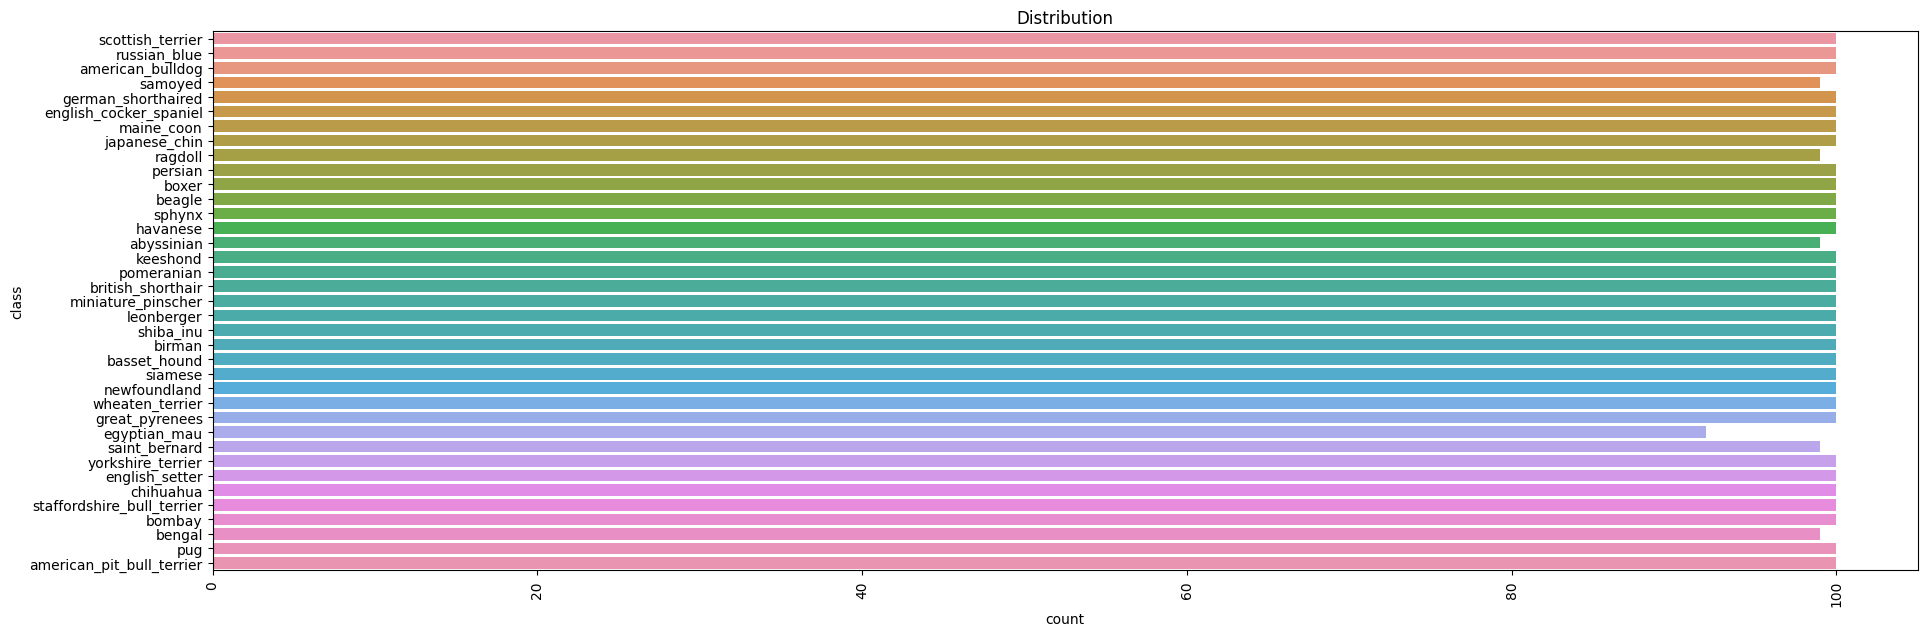

In [15]:
_, ax = plt.subplots(1, 1, figsize=(22, 7))
sns.countplot(y=df["class"], ax=ax)
ax.set_title("Distribution")
plt.xticks(rotation=90)
plt.show()

In [16]:
def view_rndm_sample():
    n = np.random.randint(0, len(df))
    im = cv2.cvtColor(cv2.imread(df.filename[n]), cv2.COLOR_BGR2RGB)
    bb.add(im, df["xmin"][n], df["ymin"][n], df["xmax"][n], df["ymax"][n],
           df["class"][n], color="green")
    cv2_imshow(im)

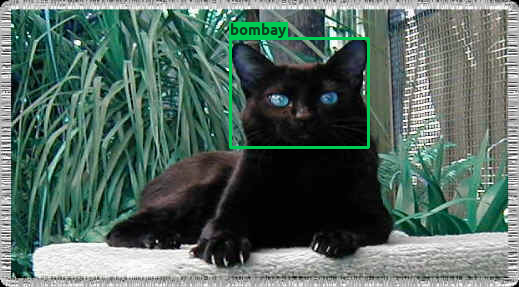

In [17]:
view_rndm_sample()

In [18]:
df.to_csv("/content/gdrive/MyDrive/pet_img_files_annots.csv", index=False)

In [19]:
df = pd.read_csv("/content/gdrive/MyDrive/pet_img_files_annots.csv")
df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/scottish_terrier_185.jpg,51.0,1.0,389.0,358.0,scottish_terrier,31
1,/content/images/Russian_Blue_146.jpg,36.0,65.0,137.0,172.0,russian_blue,28
2,/content/images/american_bulldog_124.jpg,111.0,77.0,312.0,277.0,american_bulldog,2
3,/content/images/samoyed_139.jpg,72.0,53.0,201.0,203.0,samoyed,30
4,/content/images/german_shorthaired_118.jpg,159.0,43.0,292.0,206.0,german_shorthaired,15


In [20]:
# Dictionary mapping from target to class
class_dict = {t:c for t, c in list(zip(list(df.target.unique()), list(df["class"].unique())))}
rev_label_map = {c:t for t, c in list(zip(list(df.target.unique()), list(df["class"].unique())))}

In [21]:
# class_dict
rev_label_map

{'scottish_terrier': 31,
 'russian_blue': 28,
 'american_bulldog': 2,
 'samoyed': 30,
 'german_shorthaired': 15,
 'english_cocker_spaniel': 13,
 'maine_coon': 21,
 'japanese_chin': 18,
 'ragdoll': 27,
 'persian': 24,
 'boxer': 9,
 'beagle': 5,
 'sphynx': 34,
 'havanese': 17,
 'abyssinian': 1,
 'keeshond': 19,
 'pomeranian': 25,
 'british_shorthair': 10,
 'miniature_pinscher': 22,
 'leonberger': 20,
 'shiba_inu': 32,
 'birman': 7,
 'basset_hound': 4,
 'siamese': 33,
 'newfoundland': 23,
 'wheaten_terrier': 36,
 'great_pyrenees': 16,
 'egyptian_mau': 12,
 'saint_bernard': 29,
 'yorkshire_terrier': 37,
 'english_setter': 14,
 'chihuahua': 11,
 'staffordshire_bull_terrier': 35,
 'bombay': 8,
 'bengal': 6,
 'pug': 26,
 'american_pit_bull_terrier': 3}

In [83]:
train, test = model_selection.train_test_split(df, stratify=df.target, random_state=42, shuffle=True, test_size=0.3)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print("[INFO] No. of training examples: ", len(train))
print("[INFO] No. of validation examples: ", len(test[:1000]))

[INFO] No. of training examples:  2580
[INFO] No. of validation examples:  1000


In [23]:
train.head(2)

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/saint_bernard_177.jpg,155.0,131.0,232.0,221.0,saint_bernard,29
1,/content/images/boxer_144.jpg,121.0,54.0,235.0,146.0,boxer,9


In [24]:
def get_transforms(phase):
    # Train transforms
    trn_tfms = A.Compose([
        A.ToGray(p=0.2),
        A.HorizontalFlip(),
        A.Rotate(limit=60),
        A.CLAHE(),
        A.Sharpen(),
        A.Perspective(),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

    # Validation transforms
    val_tfms = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),   
    ], p=1., bbox_params=A.BboxParams(format="pascal_voc"))
    return trn_tfms if(phase=='train') else val_tfms

In [25]:
class ParseData(Dataset):
    def __init__(self, df, trn):
        self.df = df
        self.transforms = get_transforms(trn)
                
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        # read in the image
        im = cv2.cvtColor(cv2.imread(self.df.filename[idx]), cv2.COLOR_BGR2RGB)
        # parse the bboxes
        bboxes = []
        bboxes.append(self.df.xmin[idx])
        bboxes.append(self.df.ymin[idx])
        bboxes.append(self.df.xmax[idx])
        bboxes.append(self.df.ymax[idx])

        # apply transfromations
        bboxes.append(self.df["target"][idx])
        trn_data = self.transforms(image=im, bboxes=[bboxes])
        try: 
            im, bboxes = trn_data["image"], trn_data["bboxes"][0][:4]
        except : 
            print(f"[INFO] Something wrong ... {self.df.filename[idx]}")
            sys.exit(0)

        # convert everything to torch.tensor
        image_id = torch.tensor([idx])
        trgt = torch.tensor((self.df["target"][idx], ), dtype=torch.int64)
        bboxes = torch.as_tensor([bboxes], dtype=torch.float32)
        area = torch.tensor(((bboxes[0][3] - bboxes[0][1]) * (bboxes[0][2] - bboxes[0][0]),), dtype=torch.float32)
        iscrowd = torch.zeros((1, ), dtype=torch.int64)
        # Create target dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = trgt
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return im, target

image dims:  torch.Size([3, 435, 500])
bbox coordinates:  152.0 182.0 226.0 248.0
bbox area:  4884.0
image_id:  1653
label:  9
target_dict:  {'boxes': tensor([[152., 182., 226., 248.]]), 'labels': tensor([9]), 'image_id': tensor([1653]), 'area': tensor([4884.]), 'iscrowd': tensor([0])}


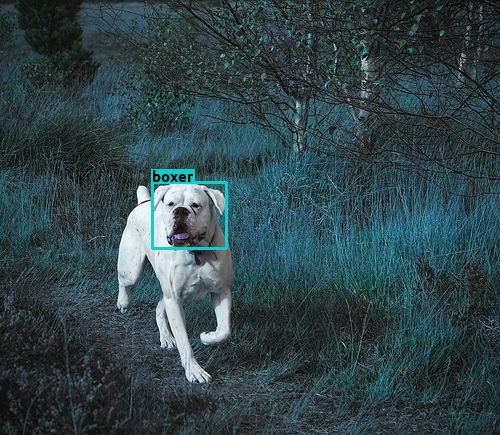

In [26]:
# Sanity Check

# Display a random sample from the dataset
n = np.random.randint(0, len(df))

tmp = ParseData(df, trn=True)
i,t = tmp.__getitem__(n)

trgt = int(t["labels"][0].numpy())

t_xmin = t["boxes"][0][0].numpy()
t_ymin = t["boxes"][0][1].numpy()
t_xmax = t["boxes"][0][2].numpy()
t_ymax = t["boxes"][0][3].numpy()

# Print Info
print("image dims: ", i.size())
print("bbox coordinates: ", t_xmin, t_ymin, t_xmax, t_ymax)
print("bbox area: ", t["area"][0].numpy())
print("image_id: ", t["image_id"][0].numpy())
print("label: ", t["labels"][0].numpy())
print("target_dict: ", t)

# De-Normalize the image?
im = i.permute(1, 2, 0).numpy()*255.0
# Add the bounding box
bb.add(im, t_xmin, t_ymin, t_xmax, t_ymax, class_dict[trgt], color="teal")
# display the image
cv2_imshow(im)
plt.show()

In [27]:
def collate_fn(batch): return tuple(zip(*batch))

In [84]:
train_loader = DataLoader(ParseData(train, True), batch_size=2, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(ParseData(test[:1000], False), batch_size=2, collate_fn=collate_fn)

In [29]:
no_classes = len(df.target.unique()) + 1
no_classes

38

In [30]:
backbone = torchvision.models.quantization.mobilenet_v3_large(pretrained=True,width_mult=1.0,  reduced_tail=False, dilated=False)
size = (320, 320)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 79.3MB/s]


In [31]:
weights_backbone = torchvision.models.detection.ssdlite.MobileNet_V3_Large_Weights.verify(torchvision.models.detection.ssdlite.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
trainable_backbone_layers = torchvision.models.detection.backbone_utils._validate_trainable_layers(
         weights_backbone is not None, 6, 6, 6
    )

norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.03)

backbone = torchvision.models.detection.ssdlite._mobilenet_extractor(
        backbone,
        trainable_backbone_layers,
        norm_layer,
    )

In [32]:
anchor_generator = torchvision.models.detection.anchor_utils.DefaultBoxGenerator([[2, 3] for _ in range(6)], min_ratio=0.2, max_ratio=0.95)
out_channels = torchvision.models.detection._utils.retrieve_out_channels(backbone, size)
num_anchors = anchor_generator.num_anchors_per_location()

In [33]:
model = torchvision.models.detection.ssdlite.SSD(backbone=backbone,anchor_generator=anchor_generator,size=(320,320),num_classes=no_classes,
                                                head=torchvision.models.detection.ssdlite.SSDLiteHead(out_channels, num_anchors, no_classes, norm_layer))
# load the model on to the computation device
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): QuantizableInvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            )
          )
          (skip_add): FloatFun

In [34]:
EPOCH = 10
LR = 0.001
BS = 8
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
print_feq = 100

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
grad_clip = True

In [36]:
from tqdm import tqdm
import time

for epoch in range(1, EPOCH+1):
    model.train()
    train_loss = []
    start_time = time.time()
    train_loss = []
    model.train()
    print(f'Epoch :{epoch}')
    for (images, targets) in train_loader:
        images = [image.to(device) for image in images]
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item()) 
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)   
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print('epoch:', epoch, '/', EPOCH,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)))

Epoch :1
epoch: 1 / 10 	train loss: 7.0867
Epoch :2
epoch: 2 / 10 	train loss: 5.5012
Epoch :3
epoch: 3 / 10 	train loss: 4.8781
Epoch :4
epoch: 4 / 10 	train loss: 4.4842
Epoch :5
epoch: 5 / 10 	train loss: 4.0175
Epoch :6
epoch: 6 / 10 	train loss: 3.7621
Epoch :7
epoch: 7 / 10 	train loss: 3.6141
Epoch :8
epoch: 8 / 10 	train loss: 3.3721
Epoch :9
epoch: 9 / 10 	train loss: 3.1598
Epoch :10
epoch: 10 / 10 	train loss: 3.0008


In [86]:
@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

    return metric_logger

In [87]:
evaluate_loss(model,test_loader,device)

Test:  [  0/500]  eta: 0:00:19  loss: 5.0074 (5.0074)  bbox_regression: 0.9935 (0.9935)  classification: 4.0139 (4.0139)  time: 0.0385  data: 0.0132  max mem: 899
Test:  [100/500]  eta: 0:00:11  loss: 4.2717 (4.3804)  bbox_regression: 0.5844 (0.6576)  classification: 3.6376 (3.7228)  time: 0.0280  data: 0.0080  max mem: 899
Test:  [200/500]  eta: 0:00:08  loss: 4.4619 (4.3407)  bbox_regression: 0.5679 (0.6292)  classification: 3.8215 (3.7115)  time: 0.0277  data: 0.0080  max mem: 899
Test:  [300/500]  eta: 0:00:06  loss: 4.9985 (4.3938)  bbox_regression: 0.6885 (0.6437)  classification: 4.1509 (3.7501)  time: 0.0426  data: 0.0150  max mem: 899
Test:  [400/500]  eta: 0:00:03  loss: 4.2161 (4.3846)  bbox_regression: 0.5623 (0.6501)  classification: 3.6193 (3.7345)  time: 0.0287  data: 0.0092  max mem: 899
Test:  [499/500]  eta: 0:00:00  loss: 4.8813 (4.4201)  bbox_regression: 0.6433 (0.6663)  classification: 3.9001 (3.7538)  time: 0.0280  data: 0.0087  max mem: 899
Test: Total time: 0:00

In [ ]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    # assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
    #     true_labels) == len(
    #     true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(class_dict)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [74]:
from random import randint
from PIL import Image, ImageDraw,ImageFont

def test(n=5):
    d = []
    model.eval()
    plt.figure(figsize=(5, 5))
    for i in range(5):
        n = np.random.randint(0, len(df))
        tmp = ParseData(df, trn=True)
        img,t = tmp.__getitem__(n)
        tsfm = get_transforms(False)
        img = img.cuda()
        output = model(img.unsqueeze(0))
        # print(calculate_mAP(output[0]['boxes'],output[0]['labels'],output[0]['scores'],t['boxes'],t['labels'],[0]))
        det_boxes, det_labels, det_scores = output[0]['boxes'],output[0]['labels'],output[0]['scores']
        det_boxes = det_boxes[0].to('cpu')
        origin_dims = torch.FloatTensor([img.size()[1], img.size()[2], img.size()[1], img.size()[2]]).unsqueeze(0)
        # transforms = torchvision.transforms.ToPILImage()
        # annotated_image = transforms(img)
        # draw = ImageDraw.Draw(annotated_image)
        img = img.permute(1, 2, 0).detach().cpu().numpy()*255.0
        box_location = det_boxes.tolist()
        bb.add(img, box_location[0], box_location[1], box_location[2], box_location[3],
           class_dict[det_labels[0].tolist()], color="green")
        
        cv2_imshow(img)
    plt.show()

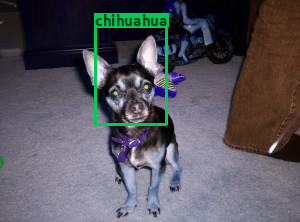

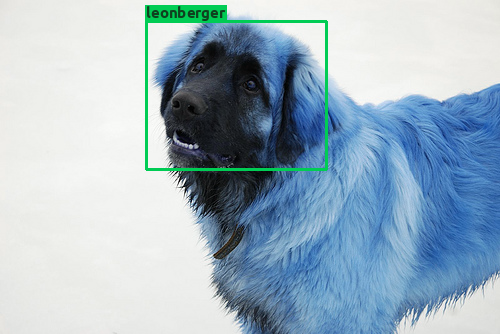

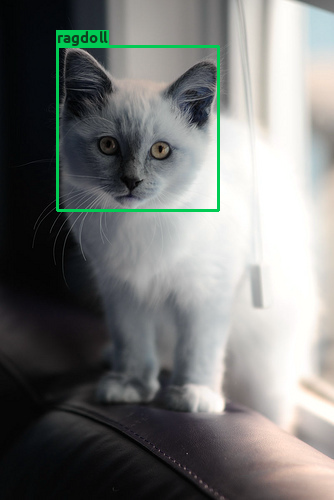

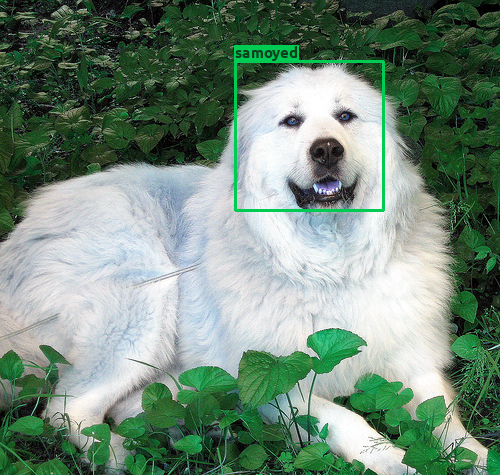

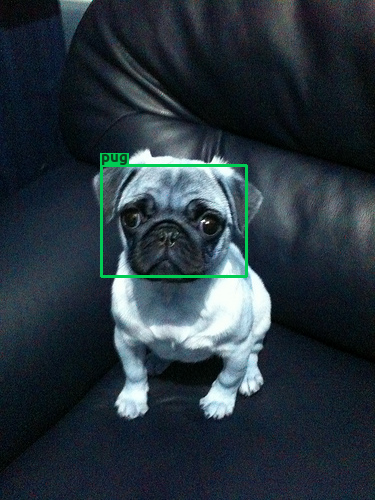

<Figure size 500x500 with 0 Axes>

In [75]:
test()

In [ ]:
# class ClassificationHead(nn.Module):
#       def __init__(self,in_channels,no_anchors,no_classes,prior_prob=0.01,norm_layer=None):
#           super().__init__()
#           conv = []
#           for i in range(4):
#               conv.append(misc.Conv2dNormActivation(in_channels,in_channels,norm_layer=norm_layer))
#           self.conv = nn.Sequential(*conv)
#           for layers in self.conv.modules():
#               torch.nn.init.xavier_uniform(layers.weight,std=0.01)
#               if(layers.bias is not None):
#                   torch.nn.init.constant_(layers.bias,0)
#           self.cls_logits = nn.Conv2d(in_channels,no_anchors*no_classes,kernel_size=3,stride=1,padding=1)
#           torch.nn.init.xavier_normal(self.cls_logits.weight,std=0.01)
#           torch.nn.init.constant_(self.cls_logits.bias,-math.log((1-prior_prob)/prior_prob))
#           self.BETWEEN_THRESHOLDS = -2
#           self.no_anchors = no_anchors
#           self.no_classes = no_classes

#       def compute_loss(self,target,output,matched_idx):
#           loss = []
#           cls_logits = output['cls_logits']
#           for tar_per_img, cls_lgt, match_id in zip(targets, cls_logits, matched_idxs):
#             # determine only the foreground
#             foreground_idx = match_id >= 0
#             no_foreground = foreground_idx.sum()

#             # create the target classification
#             gt_classes_target = torch.zeros_like(cls_lgt)
#             gt_classes_target[
#                 foreground_idx,
#                 targets_per_image["labels"][match_id[foreground_idx]],
#             ] = 1.0

#             # find indices for which anchors should be ignored
#             valid_idxs_per_image = match_id != self.BETWEEN_THRESHOLDS

#             losses.append(
#                 sigmoid_focal_loss(
#                     cls_logits_per_image[valid_idxs_per_image],
#                     gt_classes_target[valid_idxs_per_image])/ max(1, num_foreground))
            
#             return sum(losses)/len(target)
          
#       def forward(self,x):
#           all_output = []
#           for features in x:
#               out = self.conv(features)
#               out = self.cls_logits(out)
#               N,_,H,W = out.shape
#               out = out.view(N,-1,self.no_classes,H,W)
#               out = out.permute(0,3,4,1,2)
#               out = out.reshape(N,-1,self.no_classes)
#               all_output.append(out)
#           return torch.cat(all_output,dim=1)

In [ ]:
# class RegressionHead(nn.Module):
#       def __init__(self,in_channels,no_anchors,norm_layer=None):
#           super().__init__()
#           conv = []
#           for i in range(4):
#               conv.append(misc.Conv2dNormActivation(in_channels,in_channels,norm_layer=norm_layer))
#           self.conv = nn.Sequential(*conv)
#           for layers in self.conv.modules():
#               torch.nn.init.xavier_uniform(layers.weight,std=0.01)
#               if(layers.bias is not None):
#                   torch.nn.init.zeros_(layers.bias)
#           self.bbox_reg = nn.Conv2d(in_channels, no_anchors * 4, kernel_size=3, stride=1, padding=1)
#           torch.nn.init.normal_(self.bbox_reg.weight, std=0.01)
#           torch.nn.init.zeros_(self.bbox_reg.bias)
#           self.box_coder = None
#           self.loss_type = 'l1'
#       def compute_loss(self,targets,output,anchors,matched_idx):
#           losses = []
#           bbox_regression = output['bbox_regression']

#           for tar_per_img,bbox_per_img,anchors_per_img,match_idx in zip(targets,bbox_regression,anchors,matched_idx):
#               foreground_idx = torch.where(match_idx>=0)
#               no_foreground = foreground_idx.numel()

#               matched_boxes_per_image = tar_per_img["boxes"][match_idx[foreground_idx]]
#               bbox_per_img = bbox_per_img[foreground_idx, :]
#               anchors_per_image = anchors_per_img[foreground_idx, :]

#               losses.append(box_loss(self._loss_type,self.box_coder,anchors_per_image,matched_boxes_per_image,bbox_per_img)
#                             / max(1, no_foreground))
#           return sum(losses)/max(1,len(targets))

#       def forward(self,x):
#           all_output = []
#           for features in x:
#               out = self.conv(features)
#               out = self.bbox_reg(out)
#               N,_,H,W = out.shape
#               out = out.view(N,-1,4,H,W)
#               out = out.permute(0,3,4,1,2)
#               out = out.reshape(N,-1,4)
#               all_output.append(out)
#           return torch.cat(all_output,dim=1)

In [ ]:
# class RetinaNetModel(nn.Module):
#     def __init__(self,in_channels,no_anchors,no_classes,norm_layer=None):
#         super().__init__()
#         self.classification_net = ClassificationHead(in_channels,no_anchors,no_classes,norm_layer = norm_layer)
#         self.regression_net = RegressionHead(in_channels,no_anchors,norm_layer=norm_layer)

#     def compute_loss(self,targets,outputs,anchors,matched_idx):
#         return {
#             'classification': self.classification_net.compute_loss(targets,outputs,matched_idx),
#             'bbox_regression': self.regression_net.compute_loss(targets,outputs,anchors,matched_idx)
#         }

#     def forward(self,x):
#         return {
#             'cls_logits': self.classification_net(x),
#             'bbox_regression': self.regression_net(x)
#         }

In [ ]:
# def default_anchorgen():
#     anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
#     aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
#     anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
#     return anchor_generator

In [ ]:
# class RetinaNet(nn.Module):
#       def __init__(self,backbone,no_classes,min_size=800,max_size=1333,mean=None,std=None,
#                    anchor_generator=None,proposal_matcher=None,score_thresh=0.05,nms_thresh=0.5,detections_per_img=300,
#                    fg_iou_thresh=0.5,bg_iou_thresh=0.4,topk_candidates=1000,**kwargs):
#           super().__init__()
#           self.backbone = backbone
#           if anchor_generator is None:
#             anchor_generator = default_anchorgen()
#           self.anchor_generator = anchor_generator
#           if head is None:
#             head = RetinaNetModel(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], no_classes)
#           self.head = head
#           if(proposal_matcher is None):
#               proposal_matcher = None
#           self.proposal_matcher = proposal_matcher
#           if mean is None:
#             mean = [0.485, 0.456, 0.406]
#           if std is None:
#               std = [0.229, 0.224, 0.225]
#           self.transform = GeneralizedRCNNTransform(min_size, max_size, mean, std, **kwargs)
#           self.score_thresh = score_thresh
#           self.nms_thresh = nms_thresh
#           self.detections_per_img = detections_per_img
#           self.topk_candidates = topk_candidates
#       # @torch.jit.unused
#       # def eager_outputs(self, losses, detections):
#       #     if self.training:
#       #         return losses
#       #     return detections
#       def compute_loss(self, targets, outputs, anchors):
          

In [ ]:
# class MobileNetV3(nn.Module):
#     def __init__(self,inverted_residual_setting,last_channel: int,num_classes,block=None,norm_layer=None,dropout = 0.2):
#         super().__init__()


In [ ]:
# anchor_generator = AnchorGenerator(
#       sizes=((32, 64, 128, 256, 512),),
#       aspect_ratios=((0.5, 1.0, 2.0),)
#   )

In [ ]:
# def sigmoid_focal_loss(inputs,target,alpha,gamma):
#     p = torch.sigmoid(inputs)
#     ce_loss = F.binary_cross_entropy_with_logits(inputs, target, reduction="none")
#     p_t = p * target + (1 - p) * (1 - target)
#     loss = ce_loss * ((1 - p_t) ** gamma)
#     if alpha >= 0:
#         alpha_t = alpha * target + (1 - alpha) * (1 - target)
#         loss = alpha_t * loss
#     loss = loss.sum()
#     return loss

In [ ]:
# def box_loss(box_coder,anchors_per_img,):
    
#     pass